In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

## Let's first prepare some sample data (Note that we are not including an intercept term right now, as the work in this notebook is meant for illustrative purposes)

In [2]:
df = pd.read_table('https://stats.idre.ucla.edu/wp-content/uploads/2016/02/p054.txt')
df.columns = df.columns.map(str.strip)

In [3]:
x = df[['X1', 'X2']]
y = df['Y']

## What scikit-learn outputs

In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept = False)

In [5]:
lrfit = lr.fit(x,y)

In [6]:
lrfit.coef_

array([0.92658824, 0.04554397])

In [7]:
ypred = lrfit.predict(x) # predictions 
mse = sum((ypred - y)**2)/(2*len(x)) # mean squared error
mse

26.54997385929709

## Normal Equation

One can use the [normal equation](https://en.wikipedia.org/wiki/Ordinary_least_squares#Matrix/vector_formulation) for a closed-form solution for linear regression coefficients using a least-squares loss function (i.e., the mean squared error or M.S.E.). For large datasets this may not be straightforward, however, given that a matrix inverse must be computed.

In [8]:
def normaleqn_lr(x,y):
    '''
    Given: Feature matrix x and Response y
    Return: Coefficient weights b as calculated by the normal equation
    '''
    return np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T,y))

In [9]:
b_hat = normaleqn_lr(x,y)
b_hat

array([0.92658824, 0.04554397])

Let's look at the mean-squared error (m.s.e) of the linear regression coefficients given features x and response y from the normal equation. These coefficients minimize M.S.E. for the given features/response

In [10]:
def mse_lr(b, x, y):
    '''
    Given: Coefficient weights b, Feature matrix x, and Response y
    Return: Mean Square Error (M.S.E.) msqerr 
    M.S.E. is the mean of squared differences between the response y and prediction from x and current b)
    '''
    err = y - np.dot(b, x.T)
    msqerr = (1/(2*len(x))) * sum(err**2) # divide by 2, just convention so it disappears after differentiating
    return msqerr

In [11]:
mse_lr(b_hat, x, y)

26.54997385929708

## Now, let's apply (batch) gradient descent (BGD) to a least-squares loss function. First let's write a python function to perform BGD for linear regression, using a constant learning rate:

In [12]:
def bgd_lr(b, x, y, lam, tol):
    '''
    Given: 
        Initial coefficients b
        Feature matrix x
        Response y
        (Constant) Learning rate lam
        Stopping criterion tol
    Return:
        Final coefficients b
        Iteration-by-iteration coefficients b_all
        Iteration-by-iteration value of loss function f_loss
        Number of iterations to converge count
    '''
    
    # Initialize the count and comparison to stopping criterion (this will be the difference in norm between
    # current and previous coefficient weights)    
    count = 0
    #diff = 999999
    gr_norm = 999999
    
    # Initialize the "history" of the coefficient weights and M.S.E.'s
    b_all = b
    f_loss = [mse_lr(b, x, y)]
    
    # Iterate as follows:
    # -Compute gradient at current values of b, x, y
    # -Update the value of b accordingly, using a constant learning rate lam
    # -Compute norm between updated b and previous b
    # -Continue until gradient is within tolerance (i.e., declining to zero)
    while gr_norm >= tol:
        grad = -(1/len(x)) * np.dot(x.T, y-np.dot(b, x.T))
        gr_norm = np.linalg.norm(grad)
        
        b_new = b - lam * grad        
        diff = np.linalg.norm(b_new - b)
        
        b = b_new
        b_all = np.column_stack((b_all, b_new))
        f_loss.append(mse_lr(b, x, y))
        
        count += 1
    return b, b_all, f_loss, count

Now let's specify an initial set of coefficients and run with a learning rate = $10^{-4}$ and stopping criterion =$10^{-5}$

In [13]:
b_init = np.array([1,1])

In [14]:
b_final, b_all, f_loss, count = bgd_lr(b_init, x, y, .0001, .00001)

In [15]:
b_final # final coefficients, actual: (0.92658824, 0.04554397)

array([0.92658815, 0.04554408])

In [16]:
count # number of gradient descent iterations

2214

In [17]:
f_loss[-1] # M.S.E. using the final coefficients, actual: 26.54997385929708

26.549973859297786

Ok, that looks pretty good, and it didn't take TOO long to get that close.

## Effects of scaling features

First, the scikit-learn outputs

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
sc = StandardScaler()
xsc = sc.fit_transform(x)

In [20]:
lrfit_sc = lr.fit(xsc, y)

In [21]:
lrfit_sc.coef_

array([10.21544717, -0.60341119])

In [22]:
ypred = lrfit_sc.predict(xsc) # predictions 
mse = sum((ypred - y)**2)/(2*len(xsc)) # mean squared error
mse

2111.431619761391

Now, the normal equation output

In [23]:
# Coefficients
b_hat_sc = normaleqn_lr(xsc,y)
b_hat_sc

array([10.21544717, -0.60341119])

In [24]:
# MSE
mse_lr(b_hat_sc, xsc, y)

2111.431619761391

Finally, the batch gradient descent (w/constant LR) output

In [25]:
b_final_sc, b_all_sc, f_loss_sc, count_sc = bgd_lr(b_init, xsc, y, 1, .00001)

In [26]:
b_final_sc # final coefficients, actual: (10.21544717, -0.60341119)

array([10.21544642, -0.60340687])

In [27]:
count_sc # number of iterations

25

In [28]:
f_loss_sc[-1] # M.S.E. using the final coefficients, actual: 2111.431619761391

2111.4316197614

Here we see the impact of scaling the features on convergence of gradient descent for finding the linear regression coefficients -- primarily how many fewer iterations we need for convergence (25 vs. 2214!)

## Effects of the Initial Guess

Let's now return to the non-scaled features, just to check out what happens if we start with a different initial guess for the coefficients. FIrst with constant learning rate.

In [29]:
b_init2 = [10, 10]

In [30]:
b_final3, b_all3, f_loss3, count3 = bgd_lr(b_init2, x, y, .0001, .00001)

In [31]:
b_final3 # final coefficients, starting from (1,1): (0.92658815, 0.04554408)

array([0.92658815, 0.04554408])

In [32]:
count3 # 2214 starting from (1,1)

2372

In [33]:
f_loss3[-1] # M.S.E. using the final coefficients, starting from (1,1): 26.549973859297786

26.54997385929779

Not bad, again, and we are basically in the same place we ended up starting from (1,1). We have taken a bit longer (though surprisingly not by a lot) to converge than when we started at (1,1) which is much closer to the actual coefficients. Let's plot now.

In [34]:
# The M.S.E. from our initial guesses of the coefficients differ quite a bit
print(f_loss[0:2])
print(f_loss3[0:2])

[1644.9166666666667, 142.94608567367112]
[664266.0166666666, 41503.66523924675]


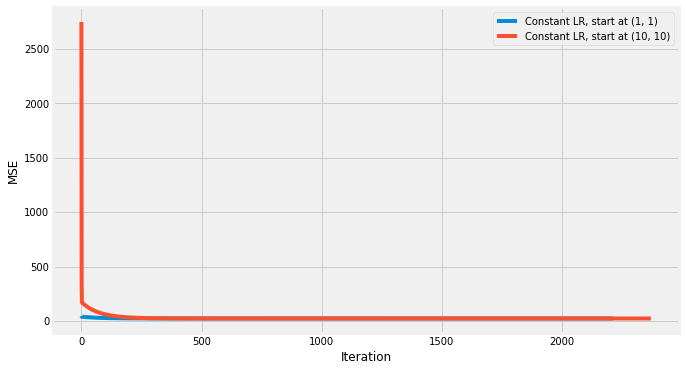

In [35]:
plt.figure(figsize=(10,6))
plt.plot(f_loss[2:])
plt.plot(f_loss3[2:])
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.legend(['Constant LR, start at (1, 1)', 'Constant LR, start at (10, 10)'])

Again, while it doesn't take substantially longer to converge in this case, we can clearly observe that initially the coefficient estimates result in much greater error -- which are nevertheless corrected quite rapidly.

## Effects of (constant) Learning Rate

Let's begin with one that is much too high (high in this case is 0.1)

In [36]:
b_final5, b_all5, f_loss5, count5 = bgd_lr(b_init, x, y, .1, .00001)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


In [37]:
b_final5

array([nan, nan])

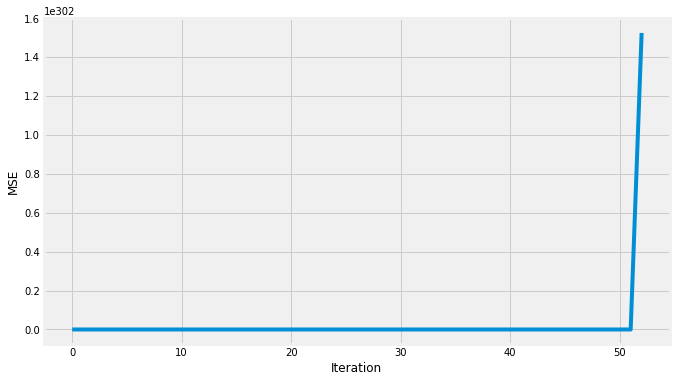

In [38]:
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.plot(f_loss5)

Batch gradient descent clearly diverges here and the M.S.E. explodes.

Now what if we choose a learning rate that's a little too small (in this case $10^{-6}$)? (Note that you have to make sure to change the stopping criterion as well in order to avoid any kind of false convergence if the learning rate is smaller than the criterion)

In [40]:
b_final6, b_all6, f_loss6, count6 = bgd_lr(b_init, x, y, .000001, .00000001)

In [41]:
b_final6

array([0.92658824, 0.04554397])

In [42]:
f_loss6[-1]

26.54997385929708

In [43]:
count6

321573

Looks good, but it took a *long* time to get there (below is a comparison between two constant LRs for the number of gradient descent iterations to converge for the faster LR)

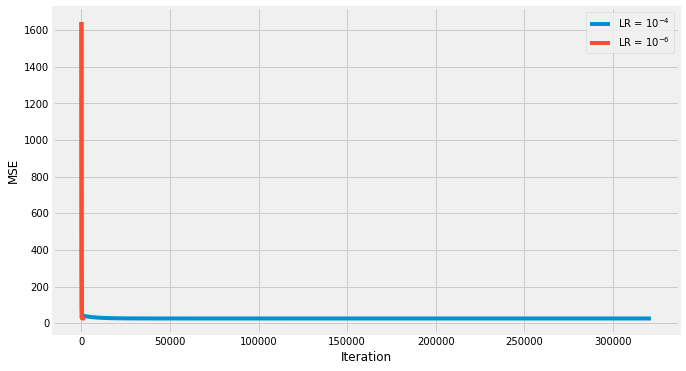

In [45]:
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.plot(f_loss6)
plt.plot(f_loss)
plt.legend(['LR = $10^{-4}$', 'LR = $10^{-6}$'])